# Sequential SAR Change Detection

In [1]:
from auxil.eeSar_seq import run
run()

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

# How to use the interface

#### To generate change maps:

    - select the desired time interval
    - use the Polygon or rectangle tool to select an ROI (default: Jülich, Germany and surroundings)
    - leave the relative orbit value at 0
    - choose orbit pass (ascending or descending), platform (S1a, S1b or both)
    - choose change map type for previewing (color-coded time of first change, last change or change frequency) or a bitemporal map for any of the consecutive time intervals
    - set a desired opacity for the preview overlay
    - leave the significance level at its default value
    - select or deselect whether to show initially a minimum cloud cover S2 image. If deselected, a temporal average of all S1 images found is displayed
    - press Collect to accumulate the images
Information about the images found is shown in the output window and an S2 image or a composite of the mean of all of the images is overlayed onto the map. If more than one relative orbit number is present, you can choose one of them by entering its value into the mask. For change detection, it is advisable not to use more than one orbit. 

    - press Collect again if desired
    - press Preview to see a preview overlay of the chosen change map 
Depending on the size of the images and their number, this can take up to a few minutes. The overlay is built up tile-by-tile as the GEE servers complete their tasks. Selecting a different change map or opacity does not require a new Run: the Preview button remains activated. You can use a water mask and/or make the no change pixels transparent with the corresponding check boxes. The color coding of the change maps is explained in the output window. Optionally use the URL displayed in the URL window to download the change maps. This may fail for longer time series and generate a corrupted ZIP file. Export to assets ot to your Google Drive is reliable. When satisfied, enter username/path in the Export to assets mask or the filename in the export to drive mask. 
    
    - Press Export to assets/drive to start an Export task on the GEE servers
An additional metadata file in CSV format is exported to the Google Drive for each asset export. The asset export will also trigger an export of the entire S1 time series as well as the S2 image (if selected) to the Google Drive if the _Export series to drive_ checkbox is set. 

You can also analyse your own image collection, if available (e.g. sentinel-1 downloaded from RSA and pre-processed wth the SNAP toolbox or preprocessed RadarSat-2 imagery). Enter the collection name in the input template and the correspnding ENL.

#### File structure

The exported or downloaded, per-pixel change maps for a time sequence of length k are combined into a single file in GeoTiff format:

    band 1 cmap: Period in which most recent significant change occured (integer 1 ... k-1)
    band 2 smap: Period in which the first significant change occurred (integer 1 ... k-1)
    bans 3 fmap: Number of significant changes (integer 1 ... k-1)
    bands 4 ... k+3: Changes in each interval (1=positive definite, 2=negative definite, 3=indefinite)
    band k+4: Sentinel 2 background image (band B8) if available, otherwise averaged VV band of the s1 series. (This is only appended on export to assets)
    
#### Fine adjustments

    - select a different significance level
The significance level applies to the tests performed in each change interval. They are statistically independent for no-change observations. 

    -select 3x3 median filter
The p-values used in the tests are filtered before testing. This has the effect of supressing single-pixel changes (salt-and-pepper effect).

    -select Quick Preview
Preview results are calculated at the scale corresponding to the current zooom level. This invalidates the ENL value so that, in general, fewer changes are detected. However calculation time is shortened, which is conveneient for rough data exploration. Unselect in order to force calcuation at the nominal scale of the data.     

#### Limits

The ROI should be completely enclosed within the S1 full scenes involved in the calculation. The larger the ROI and the longer the time series, the longer the preview and export calculations. By experience, time series longer than about 75 will cause a GEE server internal error (due to stack overflow caused by the depth of iteration).

__Reference:__ Knut Conradsen, Allan Aasbjerg Nielsen and Henning Skriver (2016). Determining the points of change in time series of polarimetric SAR data. IEEE Transactions on Geoscience and Remote Sensing 54(5), 3007-3024

http://www2.imm.dtu.dk/pubdb/views/publication_details.php?id=6825



In [3]:
%matplotlib inline

In [2]:
ls imagery/southyorkshire

users-mortcanty-southyorkshire_00.tif  users-mortcanty-southyorkshire_04.tif
users-mortcanty-southyorkshire_01.tif  users-mortcanty-southyorkshire_05.tif
users-mortcanty-southyorkshire_02.tif  users-mortcanty-southyorkshire_s2.tif
users-mortcanty-southyorkshire_03.tif


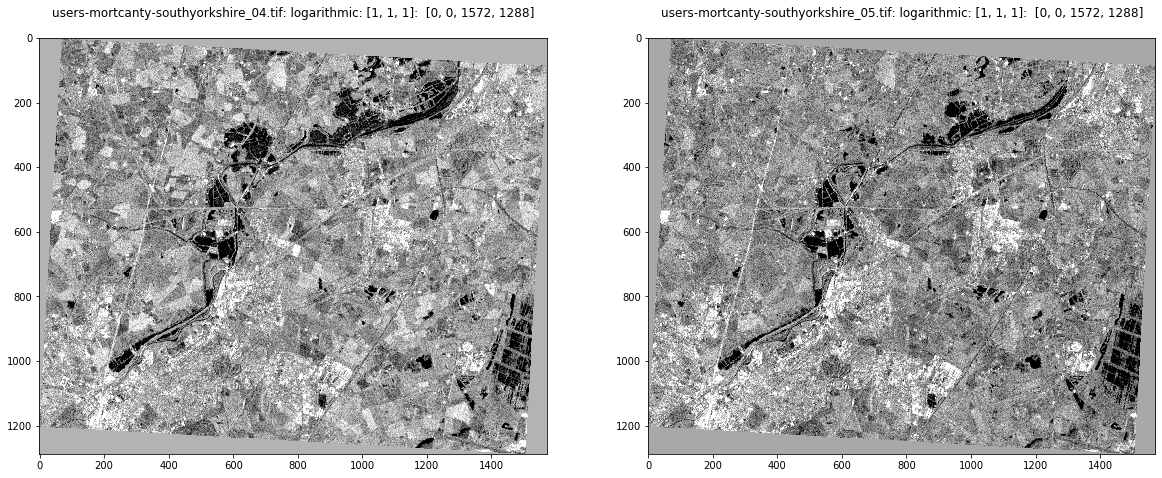

In [25]:
run scripts/dispms -f imagery/southyorkshire/users-mortcanty-southyorkshire_04.tif -F imagery/southyorkshire/users-mortcanty-southyorkshire_05.tif 